In [1]:
%pylab inline 
import pickle
import tensorflow_addons as tfa
import tensorflow as tf
import flowpm
from flowpm.tfpower import linear_matter_power
import DifferentiableHOS as DHOS
from itertools import cycle
import matplotlib.colors as mcolors
from flowpm.fourier_smoothing import fourier_smoothing
import jax_cosmo as jc

Populating the interactive namespace from numpy and matplotlib


In [2]:
from nbodykit.cosmology import Cosmology
from nbodykit.cosmology.power.halofit import HalofitPower
from astropy.cosmology import Planck15
import astropy.units as u
from flowpm import tfpm
from flowpm.utils import cic_paint, compensate_cic
from flowpm.tfpower import linear_matter_power
from functools import partial

In [3]:
# Loads PGD parameters
with open('/global/u1/d/dlan/DifferentiableHOS/notebooks/results_fit_PGD_205_128.pkl', "rb") as f:
    pgd_data = pickle.load(f)
    pgdparams = pgd_data['params']

In [4]:
# Below are a few parameters
n_lens = 11       # Number of lensplanes in the lightcone
box_size = 205.   # Transverse comoving size of the simulation volume
nc = 128          # Number of transverse voxels in the simulation volume
field_size = 5    # Size of the lensing field in degrees
field_npix = 1024 # Number of pixels in the lensing field
batch_size = 1    # Number of simulations to run in parallel
z_source = np.array([1.]) # We'll be using a single redshift for now

In [5]:
# Instantiates a cosmology with desired parameters
cosmology = flowpm.cosmology.Planck15()
# Schedule the center of the lensplanes we want for ray tracing
r = tf.linspace(0., box_size*n_lens, n_lens+1)
r_center = 0.5*(r[1:] + r[:-1])
# Retrieve the scale factor corresponding to these distances
a = flowpm.tfbackground.a_of_chi(cosmology, r)
a_center =flowpm.tfbackground.a_of_chi(cosmology, r_center)
# We run 4 steps from initial scale factor to start of raytracing
init_stages = tf.linspace(0.1, a[-1], 4)
# Then one step per lens plane
stages = tf.concat([init_stages, a_center.numpy()[::-1]], axis=0)

In [6]:
#Create some initial conditions
initial_conditions = flowpm.linear_field([nc, nc, nc],
                                         [box_size, box_size, box_size], 
                                         lambda k: tf.cast(linear_matter_power(cosmology, k), tf.complex64),         
                                         batch_size=batch_size)
initial_state = flowpm.lpt_init(cosmology, initial_conditions, 0.1)

In [7]:
nbdykit_cosmo = Cosmology.from_astropy(Planck15.clone(m_nu=0 * u.eV))
nbdykit_cosmo = nbdykit_cosmo.match(sigma8=cosmology.sigma8.numpy())

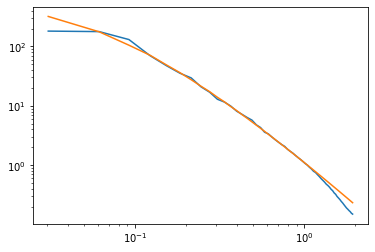

In [8]:
field = cic_paint(tf.zeros_like(initial_conditions), initial_state[0])
field = compensate_cic(field)

k, pk = flowpm.power_spectrum(
  field,
  boxsize=np.array([box_size] * 3),
  kmin=np.pi / box_size,
  dk=2 * np.pi / box_size)

target_pk = HalofitPower(nbdykit_cosmo, 1. / 0.1 - 1.)(k)

loglog(k,pk[0])
loglog(k, target_pk)

In [9]:
# Run the Nbody

states = flowpm.nbody(cosmology, 
                      initial_state, 
                      stages,
                      [nc, nc, nc],
                      return_intermediate_states=True) 



In [10]:
# Run the Nbody
states_pgd = flowpm.nbody(cosmology, 
                      initial_state, 
                      stages,
                      [nc, nc, nc],
                      return_intermediate_states=True,
                      pgdparams=pgdparams) 

In [11]:
pk_nopgd=[]
pk_pgd=[]
pk_target=[]
for i in range(len(states)):
    field = flowpm.cic_paint(tf.zeros_like(initial_conditions), states[i][1][0])
    field = compensate_cic(field)
    k, pk = flowpm.power_spectrum(field, boxsize=np.array([box_size] * 3),kmin=np.pi / box_size, dk=2 * np.pi / box_size)

    field_pgd = flowpm.cic_paint(tf.zeros_like(initial_conditions), states_pgd[i][1][0])
    field_pgd = compensate_cic(field_pgd)
    kpgd, pkpgd = flowpm.power_spectrum(field_pgd, boxsize=np.array([box_size] * 3),kmin=np.pi / box_size, dk=2 * np.pi / box_size)
    target_pk = HalofitPower(nbdykit_cosmo, 1. / states[i][0] - 1.)(k)
    pk_nopgd.append(pk)
    pk_pgd.append(pkpgd)
    pk_target.append(target_pk)

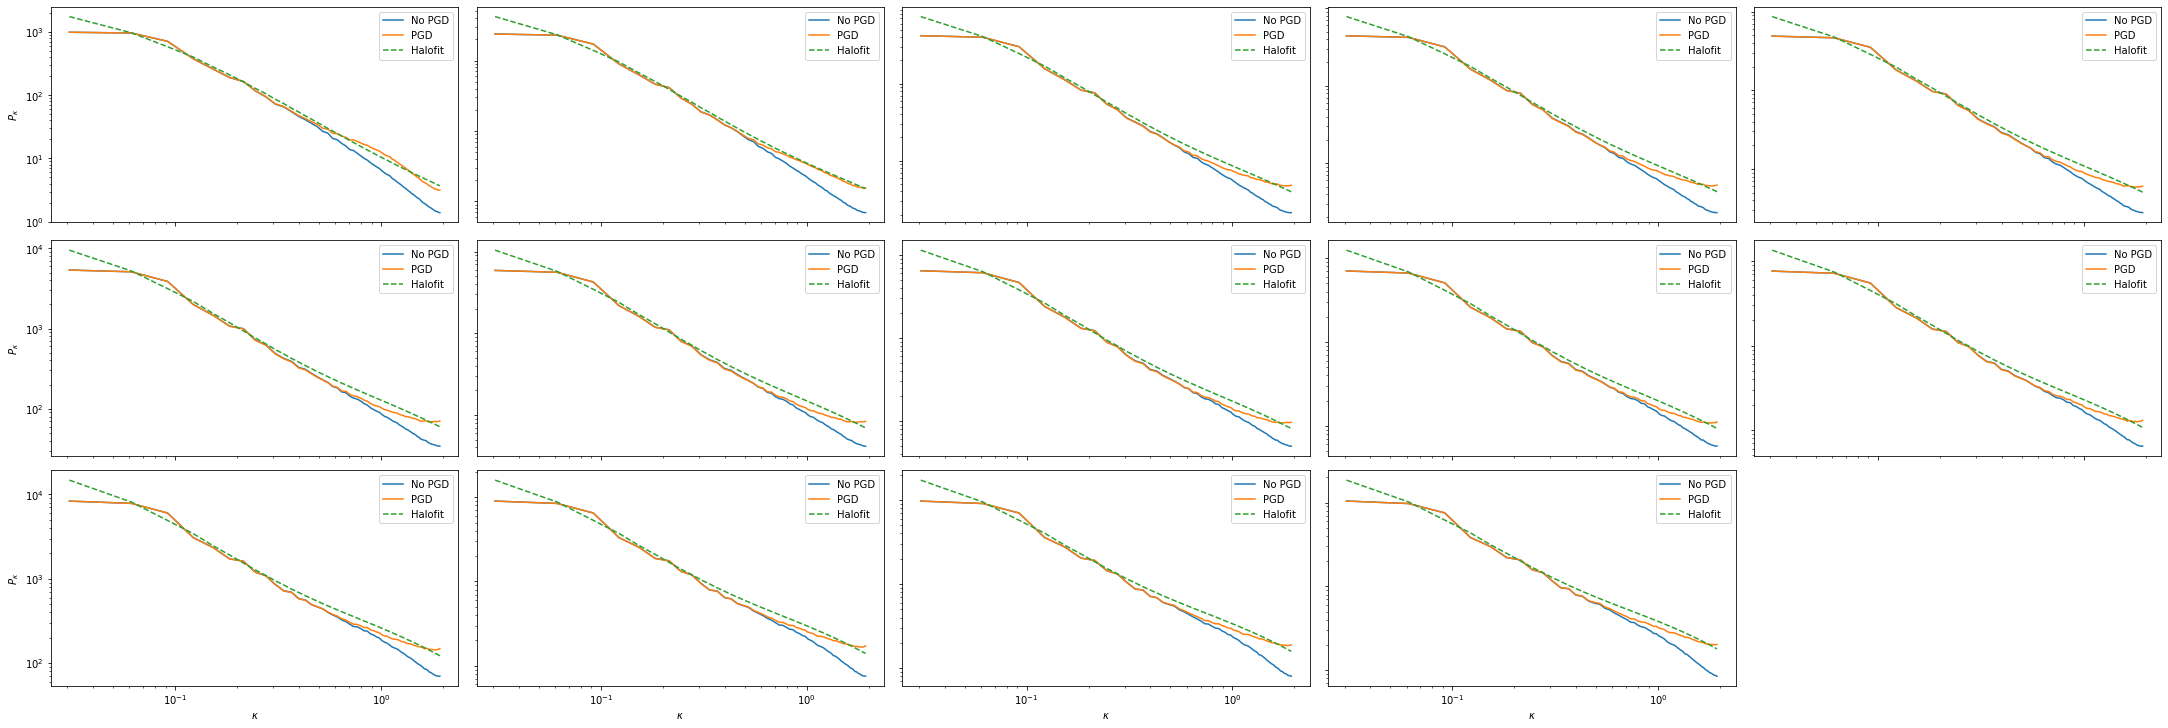

In [12]:
figsize = (30, 10)
fig =plt.figure(figsize=figsize, constrained_layout=True)
cols = 5
rows =3
ax = fig.subplots(rows, cols)
for j in range(len(states)):
    ax.flatten()[j].loglog(k, pk_nopgd[j][0],label='No PGD')
    ax.flatten()[j].loglog(k, pk_pgd[j][0],label='PGD')
    ax.flatten()[j].loglog(k, pk_target[j],'--',label='Halofit')
    ax.flatten()[j].set(xlabel=r'$\kappa$', ylabel=r'$P_{\kappa}$')
    ax.flatten()[j].legend()
    # Hide x labels and tick labels for top plots and y ticks for right plots.
    ax.flatten()[j].label_outer()
ax.flatten()[14].remove()


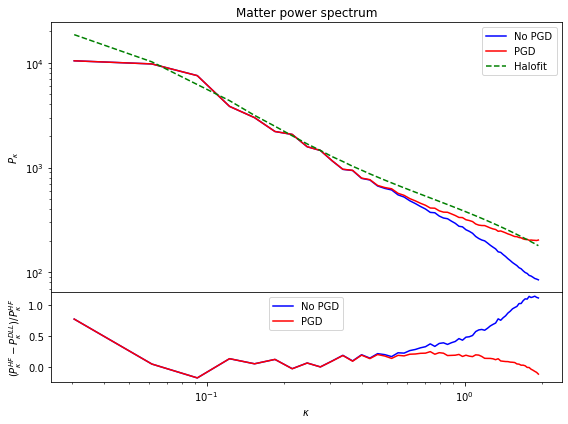

In [13]:
from matplotlib import gridspec
#style.use('seaborn-whitegrid')
# plot it
fig = plt.figure(figsize=(8, 6))

gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1],hspace=0) 
ax0 = plt.subplot(gs[0])
ax0.loglog(k, pk_nopgd[j][0],label='No PGD',color='blue')
ax0.loglog(k, pk_pgd[j][0],label='PGD',color='red')
ax0.loglog(k, pk_target[j],'--',label='Halofit',color='green')
ax0.set_title('Matter power spectrum')
plt.legend()
ax1 = plt.subplot(gs[1])
ax1.plot(k, pk_target[j]/pk_nopgd[j][0]-1,label='No PGD',color='blue')
ax1.plot(k, pk_target[j]/pk_pgd[j][0]-1,label='PGD',color='red')
ax1.set_xscale('log')
plt.legend()

ax0.set_ylabel('$P_{\kappa}$')
ax1.set_ylabel('$(P_{\kappa}^{HF}-P_{\kappa}^{DLL})/P_{\kappa}^{HF}$')
ax1.set_xlabel('$\kappa$')
plt.tight_layout()


In [14]:
%%time

# Extract the lensplanes
lensplanes = []
matrix = flowpm.raytracing.rotation_matrices()
for i, j in zip(range(len(a_center)), cycle(range(6))):
    plane = flowpm.raytracing.density_plane(states[::-1][i][1],
                                            [nc, nc, nc],
                                            nc//2,
                                            width=nc,
                                            plane_resolution=2048,
                                            rotation=matrix[j],
                                            shift=flowpm.raytracing.random_2d_shift())
    plane = fourier_smoothing(plane,sigma=1.024,resolution=2048)
    lensplanes.append((r_center[i], states[::-1][i][0], plane))

CPU times: user 48.6 s, sys: 30.5 s, total: 1min 19s
Wall time: 33.3 s


In [15]:
%%time
# Extract the lensplanes
lensplanes_pgd = []
matrix = flowpm.raytracing.rotation_matrices()
for i, j in zip(range(len(a_center)), cycle(range(6))):
    plane = flowpm.raytracing.density_plane(states_pgd[::-1][i][1],
                                            [nc, nc, nc],
                                            nc//2,
                                            width=nc,
                                            plane_resolution=2048,
                                            rotation=matrix[j],
                                            shift=flowpm.raytracing.random_2d_shift())
    plane = fourier_smoothing(plane,sigma=1.024,resolution=2048)
    lensplanes_pgd.append((r_center[i], states_pgd[::-1][i][0], plane))

CPU times: user 47.1 s, sys: 25.5 s, total: 1min 12s
Wall time: 32.1 s


In [16]:
%%time
# Get convergence map
import astropy.units as u
xgrid, ygrid = np.meshgrid(np.linspace(0, field_size, field_npix, endpoint=False), # range of X coordinates
                           np.linspace(0, field_size, field_npix, endpoint=False)) # range of Y coordinates

coords = np.stack([xgrid, ygrid], axis=0)*u.deg
c = coords.reshape([2, -1]).T.to(u.rad)

m = flowpm.raytracing.convergenceBorn(cosmology, 
                    lensplanes, 
                    dx=box_size/2048, 
                    dz=box_size,
                    coords=c,
                    z_source=z_source,
                    field_npix=field_npix)


m_pgd = flowpm.raytracing.convergenceBorn(cosmology, 
                    lensplanes_pgd, 
                    dx=box_size/2048, 
                    dz=box_size,
                    coords=c,
                    z_source=z_source,
                    field_npix=field_npix)




CPU times: user 7.76 s, sys: 2.67 s, total: 10.4 s
Wall time: 1.24 s


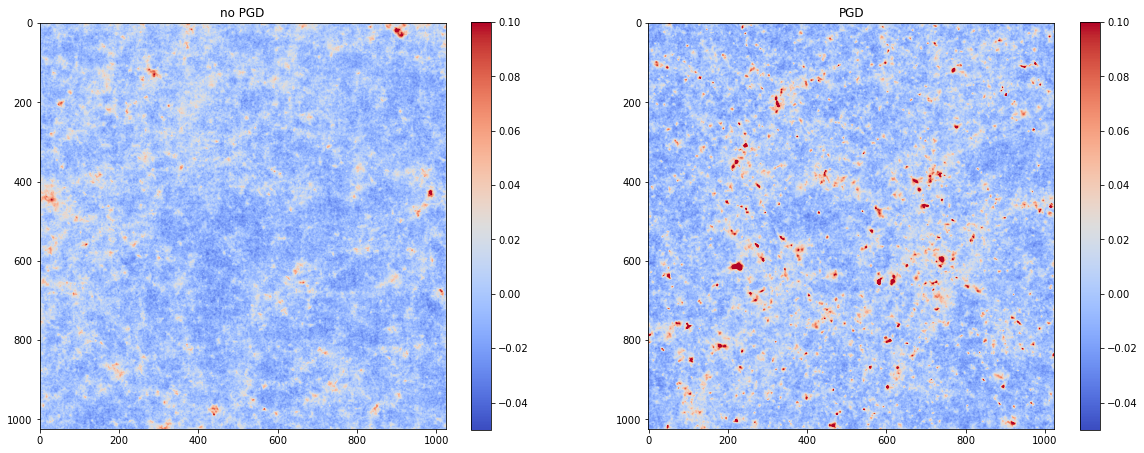

In [17]:
figure(figsize=[20,10])
subplot(121)
imshow(m[0],cmap='coolwarm',vmax=0.10,vmin=-0.05)
title('no PGD');
colorbar(shrink=0.75)
subplot(122)
imshow(m_pgd[0],cmap='coolwarm',vmax=0.10,vmin=-0.05)
title('PGD');
colorbar(shrink=0.75)

In [18]:
l,ps=DHOS.statistics.power_spectrum(m[0],field_size,field_npix)
l,ps_pgd=DHOS.statistics.power_spectrum(m_pgd[0],field_size,field_npix)

In [19]:

cosmo=jc.Planck15()
nz =jc.redshift.delta_nz(z_source)
probes = [jc.probes.WeakLensing([nz])] 
cls = jc.angular_cl.angular_cl(cosmo, l.numpy(), probes)


/global/homes/d/dlan/.local/cori/3.8-anaconda-2020.11/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:5293: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


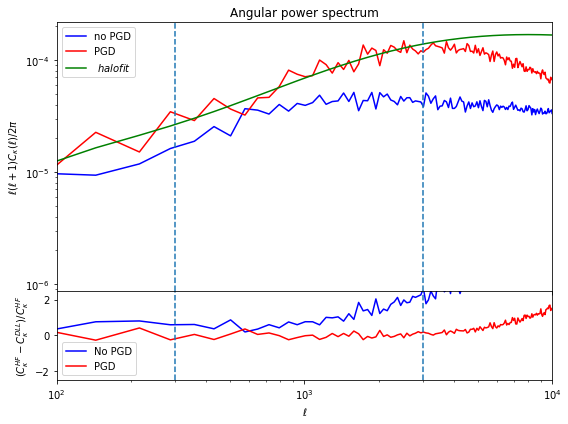

In [20]:
from matplotlib import gridspec

fig = plt.figure(figsize=(8, 6))

gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1],hspace=0) 
ax0 = plt.subplot(gs[0])
ax0.loglog(l, l*(l+1)*ps/(2*np.pi),label='no PGD',color='blue')
ax0.loglog(l, l*(l+1)*ps_pgd/(2*np.pi),label='PGD',color='red')
ax0.loglog(l, l*(l+1)*cls[0]/(2*np.pi),label=' $halofit$',color='green')
ax0.set_title('Angular power spectrum')
ax0.set_xlim(1e2,1e4)
ax0.label_outer()
ax0.set_ylabel('$\ell(\ell+1)C_{\kappa}(\ell) /2\pi$')
plt.legend()
axvline(300,ls='--')
axvline(3000,ls='--')
ax1 = plt.subplot(gs[1])
ax1.plot(l, cls[0]/ps-1,label='No PGD',color='blue')
ax1.plot(l, cls[0]/ps_pgd-1,label='PGD',color='red')
ax1.set_xscale('log')
plt.legend()
ax1.set_xlim(1e2,1e4)
ax1.set_ylabel('$(C_{\kappa}^{HF}-C_{\kappa}^{DLL})/C_{\kappa}^{HF}$')
ax1.set_xlabel('$\ell$')
ax1.set_ylim(-2.5,2.5)
axvline(300,ls='--')
axvline(3000,ls='--')
plt.tight_layout()
